In [2]:

import os
import sys
import pdb
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import random
import copy
import ipdb
import h5py
from tqdm import tqdm


import os
sys.path.insert(0, os.path.abspath('..'))


# Pipelines (a.k.a parts of the Neural Network)
from Pipelines.kitti_loader import KITTIDataset
from Pipelines.pillarizer import PillarFeatureNet, Pillarization, PseudoImageDataset
from Pipelines.backbone import BackBone
from Pipelines.detection_head import DetectionHead
from Pipelines.anchors import Box2D, Anchor
from Pipelines.loss import PointPillarLoss
from Pipelines.network import PointPillarsModel

from Utils.transformations import transform_to_canvas, transform_to_grid, map_to_img
from Utils.iou import calculate_iou
from Utils.collate import normalize_annotations
from Utils.boxes import create_boxes_tensor # FIXME: Should be in visualization instead

# Visualization tools:
from Visualization.visz_pointcloud_w_label import plot_point_cloud_with_bboxes_o3d
from Visualization.visz_bboxes import visualize_batch_bounding_boxes


# Some Neural Network Parameters:
AUG_DIM = 9
MAX_POINTS_PER_PILLAR = 100
MAX_FILLED_PILLARS = 12000
X_MIN = 0.0
X_MAX = 70.4
Y_MIN = -40.0
Y_MAX = 40.0
Z_MIN = -3.0
Z_MAX = 1.0
PILLAR_SIZE = (0.16, 0.16)
NUM_X_PILLARS = int((X_MAX - X_MIN) / PILLAR_SIZE[0])
NUM_Y_PILLARS= int((Y_MAX - Y_MIN) / PILLAR_SIZE[1])
DESIRED_CLASSES = ['Car'] # More classes can be added here
SCALE_FACTOR = 1.5
H = 500
W = 440


ANCHORS = torch.tensor([[3.9, 1.6, 1.56, -1, 0], # Anchors as tensor: (height, width, height, z_center, orientation)
                       [1.6, 3.9, 1.56, -1, 1.5708],
                       [0.8, 0.6, 1.73, -0.6, 0],
                       [0.6, 0.8, 1.73, -0.6, 1.5708]]
                       )

mapped_anchors = ANCHORS.detach().clone()
mapped_anchors[:,0:2] /= PILLAR_SIZE[0]


# Define a dictionary to map attributes to their indices
attributes_idx = {
    'norm_x': 7,
    'norm_y': 8,
    'norm_z': 9,
    'norm_h': 10,
    'norm_w': 11,
    'norm_l': 12,
}

for anchor_tensor in mapped_anchors: # NOTE: This is regardless of the batch, it is for all the training and testing
    anchor = Anchor(width=anchor_tensor[1], height=anchor_tensor[0])
    anchor.create_anchor_grid(H,W) # Creates grid
    anchor.create_anchors()
    break # FIXME: Get rid of this
    #anchors_list.append(anchor)



print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Can I can use GPU now? -- True


Load data from the KITTI dataset and perform train-test split:


In [3]:
train_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced'
train_labels_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/label_2'
test_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/testing/velodyne_reduced'

h5_file_path = '/media/adlink/6a738988-44b7-4696-ba07-3daeb00e5683/kitti_pillars/pillar_data.h5'

'''def collate_batch(batch):
    pillar_features, annotations, x_orig_indices, y_orig_indices = zip(*batch)
    
    return pillar_features, normalized_annotations, x_orig_indices, y_orig_indices'''


class HDF5PillarDataset(Dataset):
    def __init__(self, h5_file):
        self.h5_file = h5_file
        self.length = len(h5py.File(h5_file, 'r'))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as h5f:
            grp = h5f[f'point_cloud_{idx}']
            pillars = torch.from_numpy(grp['pillars'][:])
            x_indices = torch.from_numpy(grp['x_indices'][:])
            y_indices = torch.from_numpy(grp['y_indices'][:])
            label = grp['label'][:]  # If the label is not a tensor, no need for torch.from_numpy
        return pillars, label, x_indices, y_indices

hdf5_dataset = HDF5PillarDataset(h5_file_path)


# Create train loader as a torch DataLoader
train_loader = DataLoader(hdf5_dataset, batch_size=2, shuffle=True)
for batch_idx, (batched_pillars, batched_labels, batched_x_indices, batched_y_indices) in enumerate(train_loader):
    break

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/media/adlink/6a738988-44b7-4696-ba07-3daeb00e5683/kitti_pillars/pillar_data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Visualize a pointcloud with its annotations

Batch data:

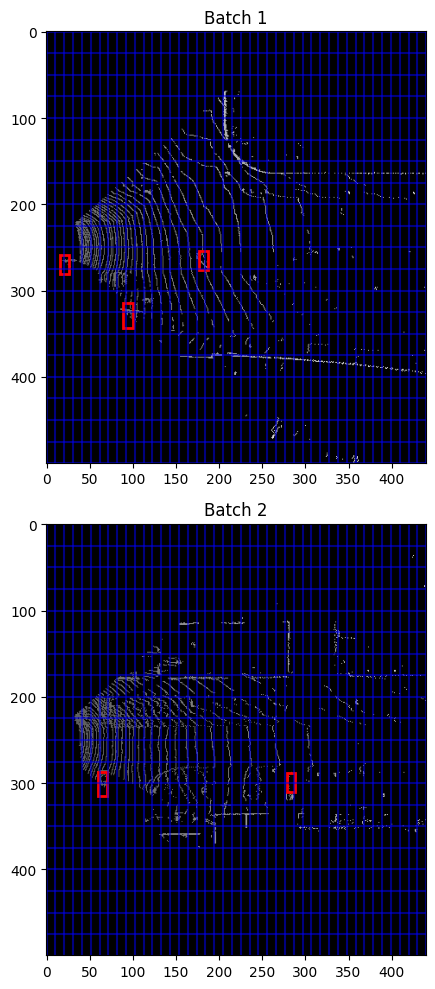

In [5]:
# Ground truth tensor of size (bs, n_boxes, 4)
gt_boxes_tensor = create_boxes_tensor(batched_labels, attributes_idx)


# Get IoU tensor and regression targets:
iou_tensor = anchor.calculate_batch_iou(gt_boxes_tensor) 
'''IoU tensor (batch_size, n_boxes, num_anchors_x, num_anchors_y)'''

regression_targets_tensor = anchor.get_regression_targets_tensor(iou_tensor, (H,W), threshold=0.5)


classification_targets_dict = anchor.get_classification_targets(iou_tensor=iou_tensor, feature_map_size=(H,W),
                            background_lower_threshold=0.05, background_upper_threshold=0.25)
'''A dictionary with keys as batch indices and values as lists of (box_index, 
feature_map_x_index, feature_map_y_index, class_label)'''


model = PointPillarsModel(device=torch.device('cuda'), aug_dim=AUG_DIM)


loc, size, clf, occupancy, angle, heading, pseudo_images, backbone_out = model(x=batched_pillars, x_orig_indices=batched_x_indices, 
                y_orig_indices=batched_y_indices, num_x_pillars=NUM_X_PILLARS, num_y_pillars=NUM_Y_PILLARS)

visualize_batch_bounding_boxes(feature_maps=pseudo_images, boxes_tensor=gt_boxes_tensor, 
                               attributes_idx=attributes_idx, visz_anchor=True, anchor=anchor)


In [4]:
loc.size()

torch.Size([2, 1, 3, 500, 440])

In [10]:
# After pillarization and batching, we can start using the GPU:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Backbone pipeline:

Text(0.5, 1.0, 'Features Summed Over Channels')

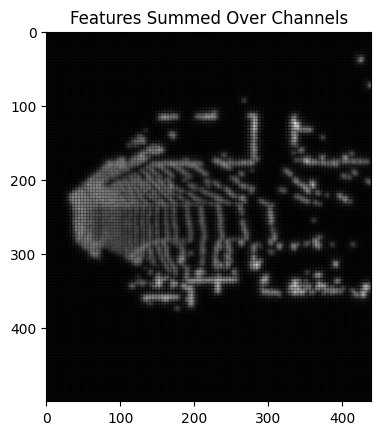

In [12]:

# Sum over channels for the original features
backbone_raw = torch.sum(backbone_out[1, :, :, :], dim=0).detach().to(torch.device('cpu')).numpy() # FIXME: Hardcoded batch_size
plt.imshow(backbone_raw, cmap='gray')
plt.title('Features Summed Over Channels')